### **Business IT Alignment Dynamics**  
The proposed model describes how alignment evolves in an organization using the discrete-time equation:  

$$
x_{t + 1} = x_t + A(x_t) - B(x_t)C(x_t)
$$
                    
Where A, B, C are defined as:  
- $ A(x_t) = d(1 - x_t) $
- $ B(x_t) = \frac{a x_t (1 - x_t)^g}{1 + a h x_t} $ 
- $ C(x_t) = \frac{1}{1 + z^s} $ where $ z = \frac{r (1 - x_t)}{x_t (1 - r)} $
        
#### **Variables and Terms**  
| **Term**       | **Description**                                                                                          | **Key Factors**                                                                 |
|----------------|----------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| **$x_t$**   | Percentage of dissatisfied end users (proxy for misalignment).                                           | State variable representing current alignment level.                           |
| **$A(x_t)$**| **Environmental pressure effect**: Captures how external dynamics (competition, tech obsolescence) increase misalignment. | $d$: Environmental dynamicity.                              |
| **$B(x_t)$**| **IT department efficacy**: Capacity to translate business needs into IT solutions.                      | $a$: IT department efficacy. <br> $h$: IT system rigidity. <br> $g$: IT investment propensity. |
| **$C(x_t)$**| **Organizational adaptability**: Capacity of the organization to adopt and exploit new IT solutions.     | $r$: Activation threshold for change. <br> $s$: Organizational flexibility. |

#### **Ranges and defaults**
| Parameter | Interpretation              | Range           | Default Value |
|-----------|-----------------------------|-----------------|---------------|
| **$x_0$** | Initial misalignment        | [0.01, 0.99]    | 0.3           |
| **$d$**   | Environmental dynamicity    | [0.1, 5]      | 0.5           |
| **$a$**   | IT department efficacy      | [0.1, 10]       | 2             |
| **$g$**   | IT investment propensity    | [0.1, 5]        | 1             |
| **$h$**   | IT system rigidity          | [0.1, 5]        | 1             |
| **$r$**   | Action threshold            | [0.01, 0.99]    | 0.3           |
| **$s$**   | Organizational flexibility  | [1, 10]         | 3             |


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, ColorPicker, FloatSlider, IntSlider, Layout, Dropdown, Output, Box, VBox, HBox
from IPython.display import display
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

In [5]:
PARAMETERS = {
    "steps": { # Beware that steps is the only Int, the other ones are all floats. 
        "default": 50,
        "description": "Number of simulation steps",
        "range": {"min": 10, "max": 200, "step": 10}
    },
    "x0": {
        "default": 0.3,
        "description": "Initial value",
        "range": {"min": 0.01, "max": 0.99, "step": 0.01}
    },
    "d": {
        "default": 0.5,
        "description": "Environmental dynamicity",
        "range": {"min": 0.1, "max": 5, "step": 0.01}
    },
    "a": {
        "default": 2,
        "description": "IT department efficacy",
        "range": {"min": 0.1, "max": 10, "step": 0.01}
    },
    "h": {
        "default": 1,
        "description": "IT system rigidity",
        "range": {"min": 0.1, "max": 5, "step": 0.01}
    },
    "g": {
        "default": 1,
        "description": "IT investment propensity",
        "range": {"min": 0.1, "max": 5, "step": 0.01}
    },
    "r": {
        "default": 0.3,
        "description": "Action threshold",
        "range": {"min": 0.01, "max": 0.99, "step": 0.01}
    },
    "s": {
        "default": 3,
        "description": "Organizational flexibility",
        "range": {"min": 1, "max": 10, "step": 0.1}
    }
}

In [10]:
def A(x, d):
    return d * (1 - x)


def B(x, a, h, g):
    return (a * x * (1 - x) ** g) / (1 + a * h * x)


def C(x, r, s):
    if x == 0:  # Avoid 0 division error
        return 0

    term1 = r * (1 - x)
    term2 = (1 - r) * x
    return 1 / (1 + (term1 / term2) ** s)

def delta(x, d, a, h, g, r, s):
    return A(x, d) - B(x, a, h, g) * C(x, r, s)

def simulate(x0 = PARAMETERS['x0']["default"], d = PARAMETERS['d']["default"], a = PARAMETERS['a']["default"], h = PARAMETERS['h']["default"], g = PARAMETERS['g']["default"], r = PARAMETERS['r']["default"], s = PARAMETERS['s']["default"], steps= PARAMETERS['steps']["default"]):
    x = np.zeros(steps)
    x[0] = x0

    for t in range(steps - 1):
        x[t + 1] = x[t] + delta(x[t], d, a, h, g, r, s)
        x[t + 1] = np.clip(x[t + 1], 0, 1)

    return x



# Interactive Long-Term Simulation
This diagram visualizes the system's temporal evolution for a specified number of steps based on initial dissatisfaction (x₀) and model parameters. By adjusting the sliders, you can explore how different conditions affect the system's behavior over time.

Additionally it classifies the equation qualitative behavior (e.g., chaotic, converging, oscillating) based on *stability* analysis.

In [7]:
slider_style = {"description_width": "80px"}
slider_layout = Layout(width="50%")

slider_args = {
    param: FloatSlider(
        min=PARAMETERS[param]["range"]["min"],
        max=PARAMETERS[param]["range"]["max"],
        step=PARAMETERS[param]["range"]["step"],
        value=PARAMETERS[param]["default"],
        description=param,
        style=slider_style,
        layout=slider_layout,
    )
    for param in PARAMETERS
    if param != "steps" # Handle steps separetely since it's not a float
}

slider_args["steps"] = IntSlider(
    min=PARAMETERS["steps"]["range"]["min"],
    max=PARAMETERS["steps"]["range"]["max"],
    step=PARAMETERS["steps"]["range"]["step"],
    value=PARAMETERS["steps"]["default"],
    description="Steps",
    style=slider_style,
    layout=slider_layout,
)

@interact(**slider_args)
def run_simulation(steps, x0, d, a, h, g, r, s):
    b_values = simulate(x0, d, a, h, g, r, s, steps)

    plt.figure(figsize=(15, 6))
    ax = plt.gca()

    plt.plot(
        b_values,
        "b-o",
        markersize=6,
        linewidth=2,
        markerfacecolor="white",
        markeredgewidth=1.5,
    )

    plt.xlabel("Iteration (t)", fontsize=12, labelpad=10)
    plt.ylabel("Dissatisfaction (x)", fontsize=12, labelpad=10)
    plt.title("Business-IT Alignment Dynamics", fontsize=14, pad=20)

    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.ylim(0, 1)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

    last_values = b_values[-10:]
    if np.std(last_values) < 0.001:
        final_val = np.mean(last_values)
        if final_val < 0.1:
            print(f"→ System converges to ALIGNED state (x = {final_val:.3f})")
        elif final_val > 0.9:
            print(f"→ System converges to MISALIGNED state (x = {final_val:.3f})")
        else:
            print(f"→ System converges to PARTIAL alignment (x = {final_val:.3f})")
    else:
        if len(np.unique(np.round(last_values, 2))) > 3:
            print("→ Chaotic behavior detected")
        else:
            print("→ System oscillates between states")

interactive(children=(IntSlider(value=50, description='Steps', layout=Layout(width='50%'), max=200, min=10, st…

# Interpreting the equation

$$
x_{t + 1} = x_t + \underbrace{A(x_t)}_{\text{Pressure}} - \underbrace{B(x_t)C(x_t)}_{\text{Recovery}}
$$

**$x_t$ - Alignement**\
Measures the percentage of dissatisfied users (proxy for Business-IT misalignment) at time $t$.  
+ $0$ = complete satisfaction
+ $1$ = utter dissatisfaction

**$A(x_t)$ - Environmental Pressure**\
*Increases* misalignment due to external factors. It represents how competitive environment and technological changes create alignment challenges.

**$B(x_t) \cdot C(x_t)$ - Recovery Mechanism**\
*Reduces* misalignment through $B(x_t)$ (IT department's effectiveness) and $C(x_t)$ (organization's adaptability).  

## Understanding the parameters

[Desmos simulation](https://www.desmos.com/calculator/qdendm1pfg).

### Environmental pressure
$ A(x_t) = d(1 - x_t) $ 

This is a line passing through the point (1, 0) with a slope of $-d$. 

- **d (dynamicity)**: fast changing industries (e.g., a tech startup) have a competition/innovation that rapidly renders old IT systems obsolete.
- **$1 - x_t$**: as misalignment grows, environmental pressure has less "room" to worsen things. 
  
### IT Department Efficacy
$ B(x_t) = \frac{a x_t (1 - x_t)^g}{1 + a h x_t} $ 

This looks like a function that peaks at some $x_a$ and then tapers off.
- **a (IT efficacy)**: an higher a can more effectively reduce misalignment.
- **x (current misalignment)**: the more misalignment exists, the more opportunity/pressure there is for IT to act.
- **$(1−x_t​)^g$ (Diminishing Returns)**: as satisfaction improves, the IT department's impact diminishes. 
  - I haven't understood g. 
- **$1 + ahx_t$ (Saturation)**: even if IT is highly capable (a >> 1), inflexible systems (h >> 1) limit its efficacy.

### Organizational Adaptability
$ C(x_t) = \frac{1}{1 + z^s} $ where $ z = \frac{r (1 - x_t)}{x_t (1 - r)} $

This is a **sigmoid** function in disguise. Sigmoids are exploited for modeling "threshold behaviors".
- **r (activation threshold)**: below r, the organization resists to change ($C(x) \rightarrow 0$). But when misalignment crosses a threshold adaptability kicks in. 
- **s (flexibility)**: higher s makes the sigmoid steeper (sharper transition between resistance/adaptation).


# Cobweb Plot

In [ ]:
from matplotlib.patches import ConnectionPatch

slider_style = {"description_width": "80px"}
slider_layout = Layout(width="50%")

slider_args = {
    param: FloatSlider(
        min=PARAMETERS[param]["range"]["min"],
        max=PARAMETERS[param]["range"]["max"],
        step=PARAMETERS[param]["range"]["step"],
        value=PARAMETERS[param]["default"],
        description=param,
        style=slider_style,
        layout=slider_layout,
    )
    for param in PARAMETERS
    if param != "steps"
}

slider_args["steps"] = IntSlider(
    min=PARAMETERS["steps"]["range"]["min"],
    max=PARAMETERS["steps"]["range"]["max"],
    step=PARAMETERS["steps"]["range"]["step"],
    value=PARAMETERS["steps"]["default"],
    description="Steps",
    style=slider_style,
    layout=slider_layout,
)

@interact(**slider_args)
def cobweb_plot(x0, d, a, h, g, r, s, steps):
    fig, ax = plt.subplots(figsize=(10, 10))
    x_values = np.linspace(0, 1, 1000)
    delta_values = np.array([delta(x, d, a, h, g, r, s) for x in x_values])
    
    next_x_values = x_values + delta_values
    
    next_x_values = np.clip(next_x_values, 0, 1)
    
    ax.plot(x_values, x_values, 'k-', label='y = x')
    
    ax.plot(x_values, next_x_values, 'r-', label='y = x + Δ(x)')
    
    x_sim = np.zeros(steps)
    x_sim[0] = x0
    
    for t in range(steps - 1):
        delta_val = delta(x_sim[t], d, a, h, g, r, s)
        x_sim[t + 1] = x_sim[t] + delta_val
        x_sim[t + 1] = np.clip(x_sim[t + 1], 0, 1)
    
    for i in range(steps - 1):
        ax.plot([x_sim[i], x_sim[i]], 
                [x_sim[i], x_sim[i+1]], 'b-', alpha=0.5)
        
        ax.plot([x_sim[i], x_sim[i+1]], 
                [x_sim[i+1], x_sim[i+1]], 'b-', alpha=0.5)
    
    # Mark the initial point
    ax.plot(x_sim[0], 0, 'go', markersize=8, label='Start')
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('x(t)', fontsize=12)
    ax.set_ylabel('x(t+1)', fontsize=12)
    ax.set_title( f'Cobweb Plot (x0={x0:.2f}, d={d:.2f}, a={a:.2f}, h={h:.2f}, g={g:.2f}, r={r:.2f}, s={s:.2f})',fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Phase Portrait

This interactive diagram visualizes the system's dynamics by plotting the rate of change (dx/dt) against misalignment (x). Adjust parameters to explore how different conditions affect the system's long-term behavior and stability properties. \
Arrows indicate direction of change, while color intensity reflects speed. Stable and unstable equilibria appear where the curve crosses zero. 


In [ ]:
def phase_portait(d, a, h, g, r, s, x_range=(0, 1), n_points=100):
    x = np.linspace(x_range[0], x_range[1], n_points)
    dx = np.array([delta(xi, d, a, h, g, r, s) for xi in x])
    
    plt.figure(figsize=(14, 6))
        
    # Plot 20 arrows evenly spaced for the derivative, letting color represent the intensity. 
    arrow_indices = np.linspace(0, len(x)-1, 20, dtype=int)
    arrow_x = x[arrow_indices]
    arrow_dx = dx[arrow_indices]
    
    norm = Normalize(vmin=0, vmax=np.max(np.abs(dx)))
    cmap = plt.cm.RdYlBu_r
    
    arrow_length = 0.02 
    arrow_head_width = 0.02
    arrow_head_length = 0.008
    arrow_y_pos = 0
    
    for xi, dxi in zip(arrow_x, arrow_dx):
        color = cmap(norm(np.abs(dxi)))
        if dxi > 0:
            plt.arrow(xi, arrow_y_pos, arrow_length, 0, 
                     head_width=arrow_head_width, 
                     head_length=arrow_head_length,
                     fc=color, ec=color, 
                     width=0.01,
                     length_includes_head=True,
                     alpha=0.9)
        elif dxi < 0:
            plt.arrow(xi, arrow_y_pos, -arrow_length, 0,
                     head_width=arrow_head_width,
                     head_length=arrow_head_length,
                     fc=color, ec=color,
                     width=0.01,
                     length_includes_head=True,
                     alpha=0.9)
    
    plt.plot(x, dx, 'k-', linewidth=1.5, alpha=0.7, label='dx/dt')
    
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical',
                        pad=0.05, shrink=0.8)
    cbar.set_label('Speed of Change (|dx/dt|)', labelpad=15)
    
    plt.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    plt.xlabel('x (Misalignement)', fontsize=11, labelpad=12)
    plt.ylabel('dx/dt', fontsize=11, labelpad=12)
    plt.title(f'ODE Phase Portrait', fontsize=13, pad=15)
    
    y_max = np.max(np.abs(dx)) * 1.1
    plt.ylim([-y_max, y_max])
    
    plt.grid(True, linestyle=':', alpha=0.3)
    plt.tight_layout()
    
    plt.show()

slider_style = {"description_width": "80px"}
slider_layout = Layout(width="50%")

slider_args = {
    param: FloatSlider(
        min=PARAMETERS[param]["range"]["min"],
        max=PARAMETERS[param]["range"]["max"],
        step=PARAMETERS[param]["range"]["step"],
        value=PARAMETERS[param]["default"],
        description=param,
        style=slider_style,
        layout=slider_layout,
    )
    for param in PARAMETERS
    if param != ("steps" or "x0") 
}

@interact(**slider_args)
def update_plot(d, a, h, g, r, s):
    phase_portait(d, a, h, g, r, s)

# Is my equation chaotic?

In [ ]:
# b is the parameter to plot on the x axis. 
def bifurcation_diagram(b_param, b_min, b_max, fixed_params, n_points=700):
    b_values = np.linspace(b_min, b_max, n_points)
    n_last = 100
    n_transient = 100

    plt.figure(figsize=(12, 7))

    for b in b_values:
        params = fixed_params.copy()
        params[b_param] = b
        
        x = PARAMETERS["x0"]["default"]
        
        for _ in range(n_transient):
            x = np.clip(x + delta(x, **params), 0, 1)
        
        x_vals = []
        for _ in range(n_last):
            x = np.clip(x + delta(x, **params), 0, 1)
            x_vals.append(x)
        
        plt.plot([b] * len(x_vals), x_vals, 'k.', markersize=0.5, alpha=0.6)

    plt.title(f"Bifurcation Diagram (varying {b_param})", fontsize=14)
    plt.xlabel(f"{b_param} ({PARAMETERS[b_param]['description'] if b_param in PARAMETERS else ''})", fontsize=12)
    plt.ylabel("Long-term x value", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()
    
def update_bif_diagram(b_param, b_min, b_max, **kwargs):
    fixed_params = kwargs.copy()
    
    required_params = ['d', 'a', 'h', 'g', 'r', 's']
    for p in required_params:
        if p not in fixed_params and p != b_param:
            fixed_params[p] = PARAMETERS[p]['default']
            
    bifurcation_diagram(b_param, b_min, b_max, fixed_params)



In [ ]:
def create_interactive():
    slider_style = {"description_width": "80px"}
    slider_layout = Layout(width="50%")
    initial_param = 'd'
    
    available_params = [p for p in PARAMETERS.keys() if p not in ['x0', 'steps']]
    param_dropdown = Dropdown(
        options=available_params,
        value=initial_param,
        description='Parameter:'
    )
    
    b_min_slider = FloatSlider(
        min=PARAMETERS[initial_param]['range']['min'],
        max=PARAMETERS[initial_param]['range']['max'],
        step=PARAMETERS[initial_param]['range']['step'],
        value=PARAMETERS[initial_param]['range']['min'],
        style=slider_style,
        layout=slider_layout,
        description='Min value:'
    )
    
    b_max_slider = FloatSlider(
        min=PARAMETERS[initial_param]['range']['min'],
        max=PARAMETERS[initial_param]['range']['max'],
        step=PARAMETERS[initial_param]['range']['step'],
        value=PARAMETERS[initial_param]['range']['max'],
        style=slider_style,
        layout=slider_layout,
        description='Max value:'
    )
    
    other_sliders = {}
    for param in PARAMETERS:
        if param not in ['x0', 'steps']:
            other_sliders[param] = FloatSlider(
                min=PARAMETERS[param]['range']['min'],
                max=PARAMETERS[param]['range']['max'],
                step=PARAMETERS[param]['range']['step'],
                value=PARAMETERS[param]['default'],
                style=slider_style,
                layout=slider_layout,
                description=f"{param}",
                disabled=(param == initial_param)  # Initially disable 'd'
            )
    
    current_b_param = {'value': initial_param}
    
    def update_sliders(change):
        new_param = change['new']
        old_param = current_b_param['value']
        current_b_param['value'] = new_param

        b_min_slider.min = PARAMETERS[new_param]['range']['min']
        b_min_slider.max = PARAMETERS[new_param]['range']['max']
        b_min_slider.step = PARAMETERS[new_param]['range']['step']
        b_min_slider.value = PARAMETERS[new_param]['range']['min']
        
        b_max_slider.min = PARAMETERS[new_param]['range']['min']
        b_max_slider.max = PARAMETERS[new_param]['range']['max']
        b_max_slider.step = PARAMETERS[new_param]['range']['step']
        b_max_slider.value = PARAMETERS[new_param]['range']['max']
        
        if old_param in other_sliders:
            other_sliders[old_param].disabled = False
        
        if new_param in other_sliders:
            other_sliders[new_param].disabled = True
    
    param_dropdown.observe(update_sliders, names='value')
    
    # Wrapper function
    def wrapper(b_min, b_max, **kwargs):
        return update_bif_diagram(
            b_param=current_b_param['value'],
            b_min=b_min,
            b_max=b_max,
            **kwargs
        )
    
    # Create interactive widget
    interactive_plot = interactive(
        wrapper,
        b_min=b_min_slider,
        b_max=b_max_slider,
        **other_sliders
    )
    
    # Create a vertical layout with dropdown first, then the interactive plot
    from ipywidgets import VBox
    return VBox([param_dropdown, interactive_plot])

create_interactive()

## Lyapunov exponent

In [38]:
def compute_lyapunov_exponent(x0=0.3, epsilon=1e-8, steps=50, **kwargs):


    x = simulate(x0=x0, steps=steps, **kwargs)
    x_perturbed = simulate(x0=x0 + epsilon, steps=steps, **kwargs)
    

    separation = np.abs(x_perturbed - x)
    
    valid_indices = separation > 0
    if np.sum(valid_indices) < 2:
        return 0
    
    t = np.arange(steps)[valid_indices]
    log_sep = np.log(separation[valid_indices])
    
    # Perform linear regression
    coeffs = np.polyfit(t, log_sep, 1)
    lyapunov_exponent = coeffs[0]
    
    return lyapunov_exponent


print(compute_lyapunov_exponent())
print(compute_lyapunov_exponent(x0=0.5, d=0.7, a=2.5))
print(compute_lyapunov_exponent(x0=0.3, d=1, a=1, h=1, g=1, r=0.5, s=1))



-0.3835174630858553
-0.0759472441203858
-0.7033547729408566


# Case of interests

## Alignment as a function of x and y

Find how variations in couple of parameters, such as *a* (efficiency) and *h* (rigidity), affect the long term alignment.

- X-axis: First parameter
- Y-axis: Second parameter
- Compute the long term alignment (mean of iterations 90-100) and display it as: 
  - Color gradient.   
  - Contour lines.   

The couples of parameters tested are the following:
1. (*a*, *h*)  
2. (*a*, *g*)  
3. (*h*, *g*)  
4. (*r*, *s*)  

In [13]:
def contourmap_builder(par_1, delta_1, par_2, delta_2, quality=100, levels=10, 
                      ax_color='orange', colormap=plt.cm.Blues, save_loc=None):

    
    par_1_values = np.linspace(PARAMETERS[par_1]['default'] - delta_1, 
                              PARAMETERS[par_1]['default'] + delta_1, 
                              quality)
    par_2_values = np.linspace(PARAMETERS[par_2]['default'] - delta_2, 
                              PARAMETERS[par_2]['default'] + delta_2, 
                              quality)
    
    grid_1, grid_2 = np.meshgrid(par_1_values, par_2_values)
    equilibrium_values = np.zeros_like(grid_1)
    
    for i in range(len(par_1_values)):
        for j in range(len(par_2_values)):
            params = {
                par_1: grid_1[j, i],
                par_2: grid_2[j, i]
            }
                      
            output = simulate(**params)
            equilibrium_values[j, i] = np.mean(output[-10:])
    
    plt.figure(figsize=(10, 8))
    
    contour = plt.contour(grid_1, grid_2, equilibrium_values, 
                         levels=levels, colors='black', linewidths=0.7, alpha=1)
    plt.clabel(contour, inline=True, fontsize=8, colors='black')

    norm = Normalize(vmin=np.min(equilibrium_values), vmax=1)
    plt.pcolormesh(grid_1, grid_2, equilibrium_values, 
                  shading='auto', cmap=colormap, norm=norm)
    
    cbar = plt.colorbar()
    cbar.set_label('Alignment')
    
    plt.axhline(y=PARAMETERS[par_2]['default'], color=ax_color, 
                linestyle='--', linewidth=1)
    plt.axvline(x=PARAMETERS[par_1]['default'], color=ax_color, 
                linestyle='--', linewidth=1)
    plt.scatter(PARAMETERS[par_1]['default'], PARAMETERS[par_2]['default'], 
               color=ax_color, marker='x', label='Default parameters')
    
    plt.xlabel(f"{par_1} ({PARAMETERS[par_1]['description']})")
    plt.ylabel(f"{par_2} ({PARAMETERS[par_2]['description']})")
    plt.title(f'Alignment as function of {par_1} and {par_2}')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    
    if save_loc:
        plt.savefig(
            save_loc,
            dpi=400,
            bbox_inches="tight",
            transparent=False,
        )
    plt.show()

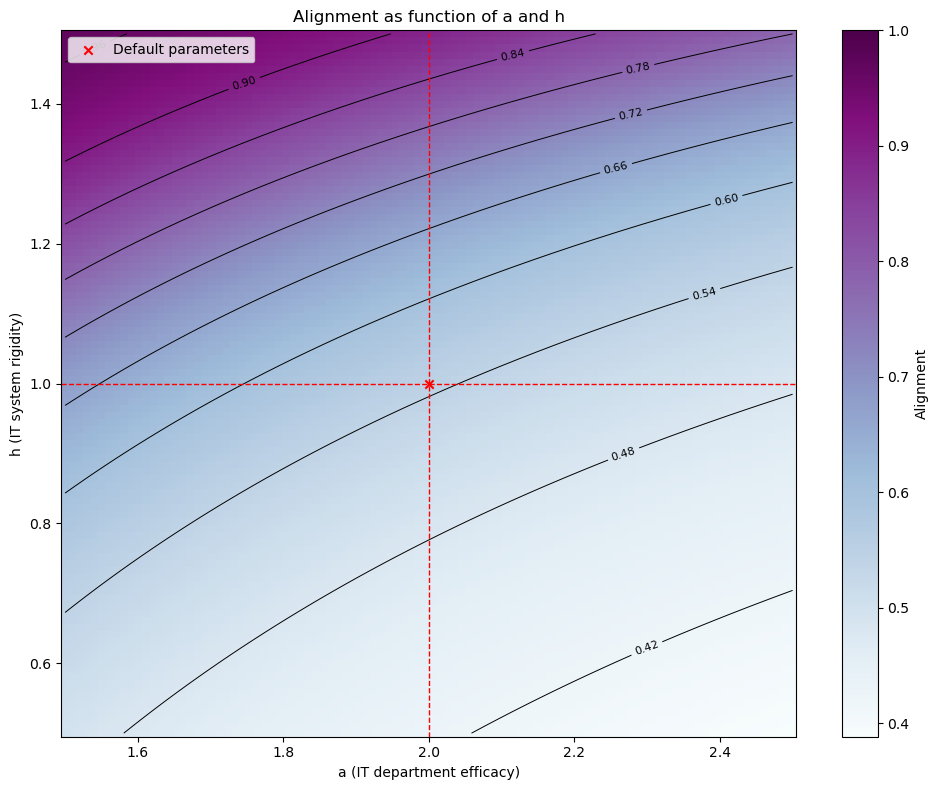

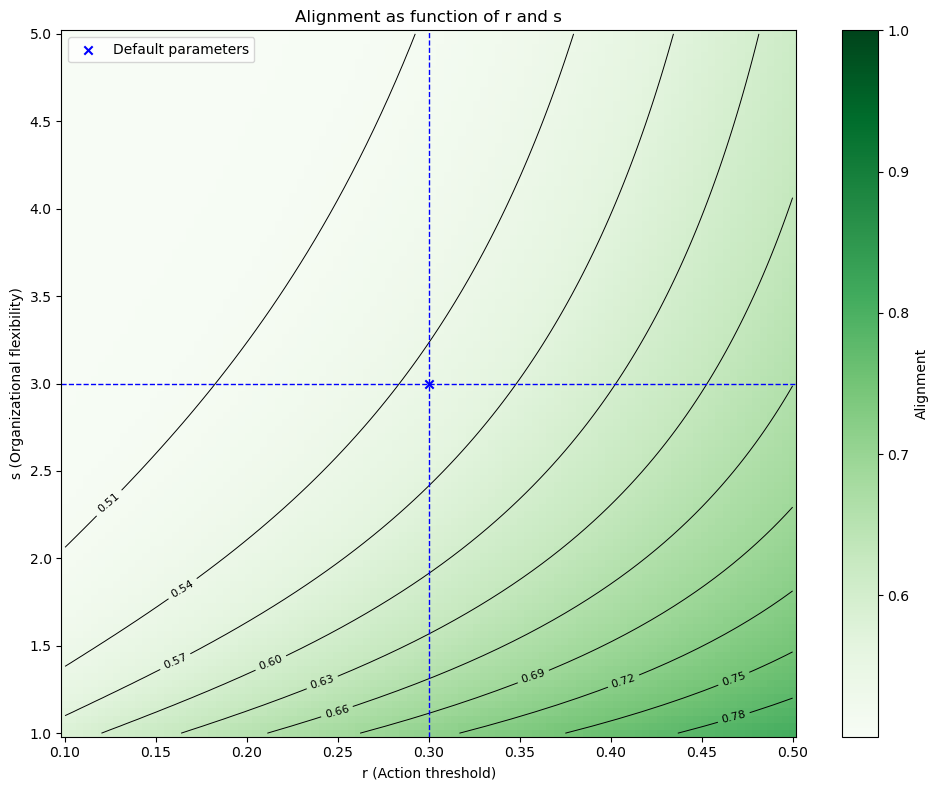

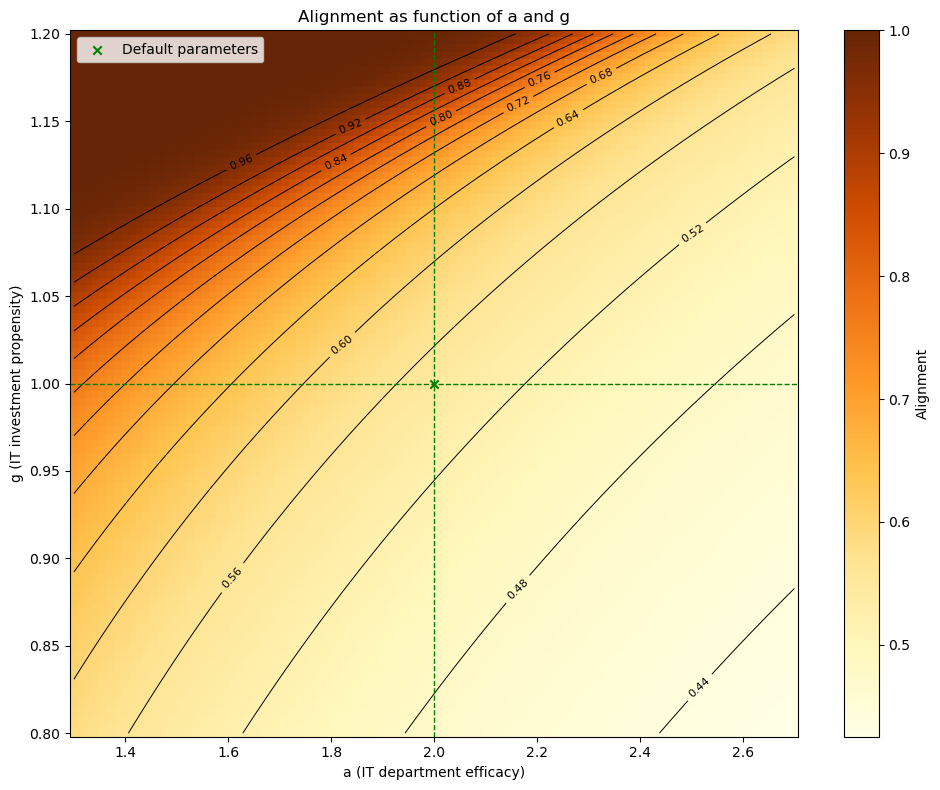

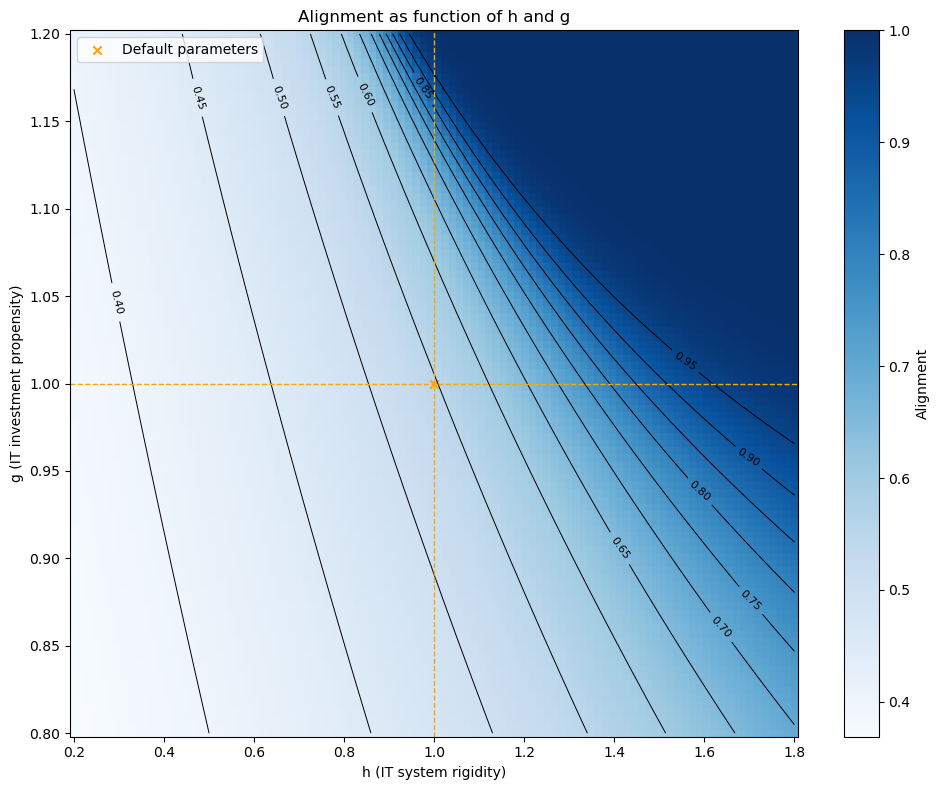

In [14]:
contourmap_builder('a', 0.5, 'h', 0.5, 100, 10, 'red', plt.cm.BuPu, None)
contourmap_builder('r', 0.2, 's', 2, 100, 10, 'blue', plt.cm.Greens, None)
contourmap_builder('a', 0.7, 'g', 0.2, 100, 14, 'green', plt.cm.YlOrBr, None)
contourmap_builder('h', 0.8, 'g', 0.2, 100, 14, 'orange', plt.cm.Blues, None)

## Basin Attraction Diagram

In [ ]:
def create_attraction_basin_scatter(resolution=70, dot_size=4):
    
    param_widget = Dropdown(
        options=list(p for p in PARAMETERS.keys() if p not in ['x0', 'steps']),
        value='d',
        description='Y-axis parameter:',
        disabled=False,
        style={'description_width': 'initial'}
    )
    
    scale_widget = Dropdown(
        options=['linear', 'log'],
        value='log',
        description='Y-axis scale:',
        disabled=False,
        style={'description_width': 'initial'}
    )
    
    low_color_picker = ColorPicker(
        concise=False,
        description='Low value color:',
        value='#440154',  # Default dark purple
        disabled=False,
        style={'description_width': 'initial'}
    )
    
    high_color_picker = ColorPicker(
        concise=False,
        description='High value color:',
        value='#fde725',  # Default bright yellow
        disabled=False,
        style={'description_width': 'initial'}
    )
    
    def create_custom_colormap(low_color, high_color):
        return LinearSegmentedColormap.from_list('custom', [low_color, high_color])
    
    out = Output()
    
    def update_plot(param, scale, low_color, high_color):
        with out:
            out.clear_output(wait=True)
            
            x0_values = np.linspace(0.01, 0.99, resolution)
            
            if scale == 'log':
                param_values = np.logspace(
                    np.log10(PARAMETERS[param]['range']['min']),
                    np.log10(PARAMETERS[param]['range']['max']),
                    resolution
                )
            else:
                param_values = np.linspace(
                    PARAMETERS[param]['range']['min'],
                    PARAMETERS[param]['range']['max'],
                    resolution
                )
            
            x0_points = []
            param_points = []
            color_values = []
            
            for x0 in x0_values:
                for p_value in param_values:
                    
                    kwargs = {
                        'x0': x0,
                        param: p_value
                    }
                    
                    x_series = simulate(**kwargs)
                    
                    x0_points.append(x0)
                    param_points.append(p_value)
                    color_values.append(np.mean(x_series[-10:]))
            
            plt.figure(figsize=(10, 8))
            
            cmap = create_custom_colormap(low_color, high_color)
            
            scatter = plt.scatter(
                x0_points, 
                param_points, 
                c=color_values,
                s=dot_size,
                cmap=cmap,
                vmin=0,
                vmax=1
            )
            
            plt.yscale(scale)
            
            cbar = plt.colorbar(scatter)
            cbar.set_label('Alignment')
            
            plt.xlabel('Initial condition (x₀)', fontsize=12)
            ylabel = f'{param} ({PARAMETERS[param]["description"]})'
            if scale == 'log':
                ylabel += ' (log scale)'
            plt.ylabel(ylabel, fontsize=12)
            
            title = f'Attraction Basin Scatter Plot\n(x₀ vs {param}, {scale} scale)'
            plt.title(title, fontsize=14)
            
            plt.grid(True, linestyle='--', alpha=0.3, which='both')
            
            if scale == 'log':
                plt.gca().yaxis.set_minor_formatter(plt.ScalarFormatter())
            
            plt.tight_layout()
            plt.show()
    
    interactive(
        update_plot,
        param=param_widget,
        scale=scale_widget,
        low_color= low_color_picker,
        high_color=high_color_picker
    )
    
    display(VBox([
        HBox([param_widget, Box(layout=Layout(width='50px')), scale_widget]),
        Box(layout=Layout(height='20px')),
        HBox([low_color_picker,  Box(layout=Layout(width='50px')), high_color_picker])
    ]))
    display(out)


create_attraction_basin_scatter()

Output()